<a href="https://colab.research.google.com/github/ted-marlon/Data-Science/blob/main/Project_ARIMA_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Présentation de la problématique

La base de données AirPassengers est une série temporelle classique qui représente le nombre mensuel de passagers aériens internationaux. Elle est souvent utilisée comme exemple pour illustrer les modèles de prévision, y compris les modèles ARIMA.

La base de données AirPassengers contient les colonnes suivantes :

Month : La date (mois et année) de chaque observation.
Passengers : Le nombre de passagers aériens internationaux pour chaque mois.
Les données de la base AirPassengers couvrent la période de janvier 1949 à décembre 1960, soit 12 années de données mensuelles.

# Importation des packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# Chargement de la base de données

In [3]:
df=pd.read_csv("AirPassengers.csv")

In [4]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
# Renommage de la colonne
df.rename(columns={'#Passengers':'Passengers'},inplace=True)
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Notre base de données comporte 144 observations pour deux variables à savoir la date et le nombre de passagers.

# Feature Engineering

In [8]:
# Conversion de la date en datetime
from datetime import datetime
df['Month']=pd.to_datetime(df['Month'],infer_datetime_format=True)
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [9]:
# Mettre la date en index de la table
df.set_index('Month',inplace=True)
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Méthodologie de Box-Jenkins

# 1. Identification du modèle




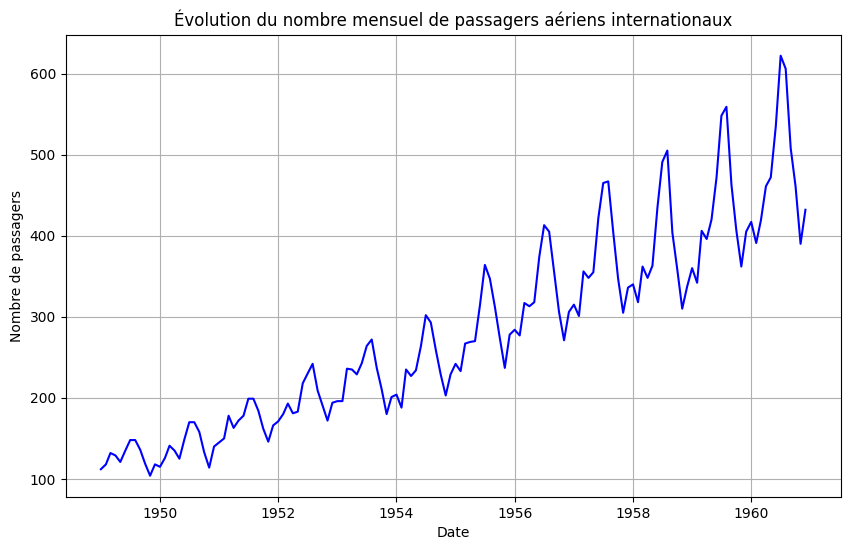

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Passengers'], color='blue')
plt.title('Évolution du nombre mensuel de passagers aériens internationaux')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.grid(True)
plt.show()

En regardant la courbe, nous observons une tendance croissante et des propriétés statistiques qui changent au cours du temps..
Cela signifie que notre serie temporelle n'est pas stationnaire.
De ce fait, nous avons besoin d'utiliser une méthode de modélisation comme ARIMA ou SARIMA.

Verification Statistique de la stationnarité.

In [11]:
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(df)

# Extraire les résultats principaux
valeur_test = result[0]
p_valeur = result[1]
nb_lags = result[2]
nb_obs = result[3]
valeurs_critiques = result[4]

# Construire le tableau de résultats
table = [
    ['Statistique de test', valeur_test],
    ['P-valeur', p_valeur],
    ['Nombre de retards (lags)', nb_lags],
    ['Nombre d\'observations', nb_obs],
    ['Valeur critique (1%)', valeurs_critiques['1%']],
    ['Valeur critique (5%)', valeurs_critiques['5%']],
    ['Valeur critique (10%)', valeurs_critiques['10%']],
    ['Conclusion', 'La serie est stationnaire' if p_valeur < 0.05 else 'le serie n est pas  stationnaire']
]

# Afficher dans un tableau bien présenté
print(tabulate(table, headers=['Paramètre', 'Valeur'], tablefmt='fancy_grid', floatfmt=".4f"))


╒══════════════════════════╤══════════════════════════════════╕
│ Paramètre                │ Valeur                           │
╞══════════════════════════╪══════════════════════════════════╡
│ Statistique de test      │ 0.8153688792060498               │
├──────────────────────────┼──────────────────────────────────┤
│ P-valeur                 │ 0.991880243437641                │
├──────────────────────────┼──────────────────────────────────┤
│ Nombre de retards (lags) │ 13                               │
├──────────────────────────┼──────────────────────────────────┤
│ Nombre d'observations    │ 130                              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (1%)     │ -3.4816817173418295              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (5%)     │ -2.8840418343195267              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (10%)    │ -2.57877005

Détermination des paramètres du modèle ARIMA : p, d et q

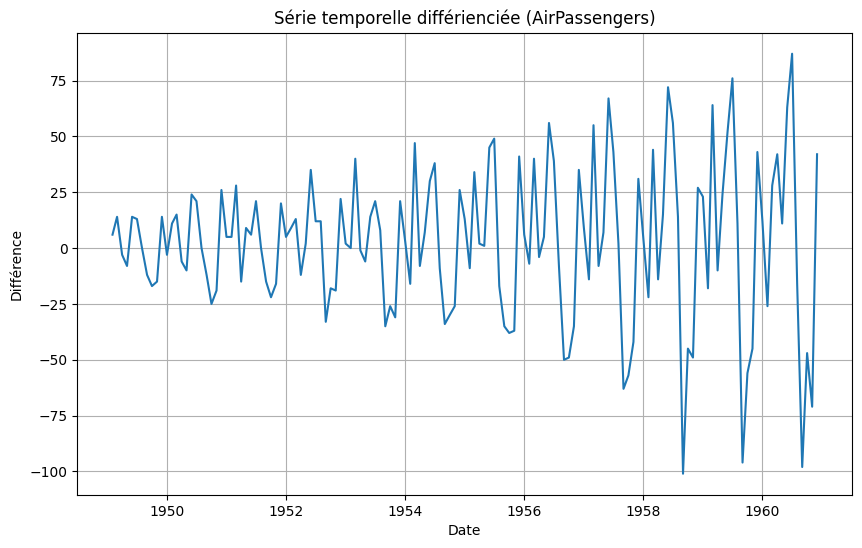

In [12]:
# Différenciation pour rendre la série stationnaire
differenced = df['Passengers'].diff().dropna()

# Afficher la série différienciée
plt.figure(figsize=(10, 6))
plt.plot(differenced)
plt.title('Série temporelle différienciée (AirPassengers)')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

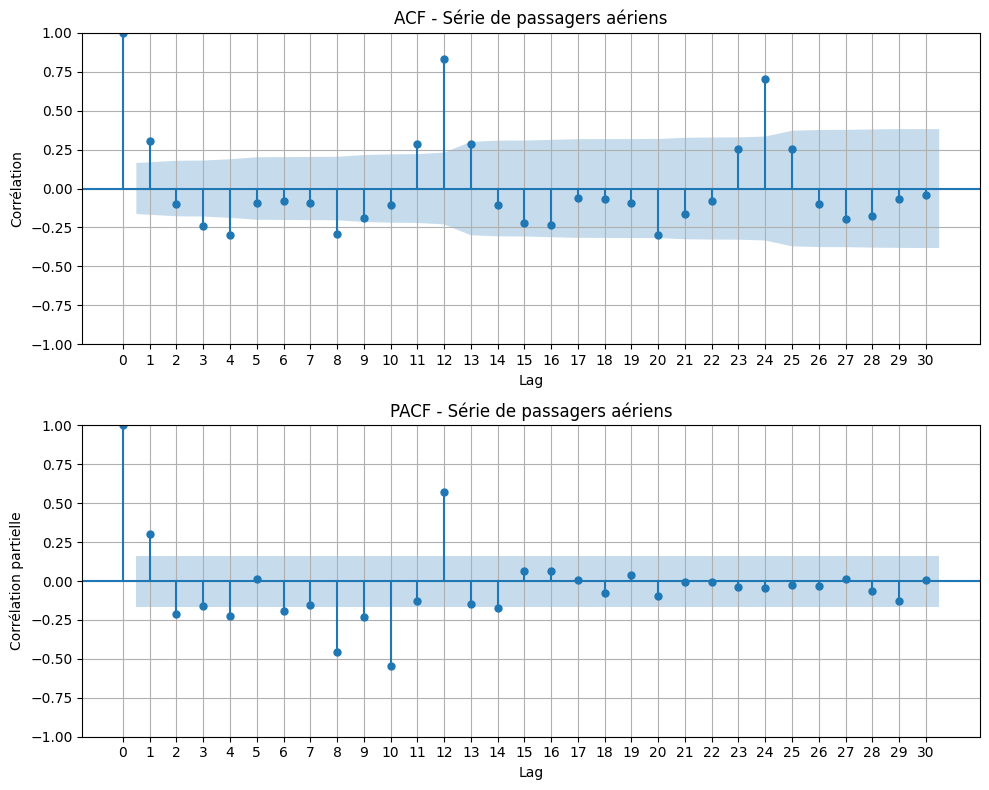

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série de passagers aériens')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série de passagers aériens')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()


In [16]:
# Analyse de la stationnarité de la variable
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(differenced)

valeur_test = result[0]
p_valeur = result[1]
nb_lags = result[2]
nb_obs = result[3]
valeurs_critiques = result[4]

# Construire le tableau de résultats
table = [
    ['Statistique de test', valeur_test],
    ['P-valeur', p_valeur],
    ['Nombre de retards (lags)', nb_lags],
    ['Nombre d\'observations', nb_obs],
    ['Valeur critique (1%)', valeurs_critiques['1%']],
    ['Valeur critique (5%)', valeurs_critiques['5%']],
    ['Valeur critique (10%)', valeurs_critiques['10%']],
    ['Conclusion', 'La serie est stationnaire' if p_valeur < 0.05 else 'le serie n est pas  stationnaire']
]

# Afficher dans un tableau bien présenté
print(tabulate(table, headers=['Paramètre', 'Valeur'], tablefmt='fancy_grid', floatfmt=".4f"))


╒══════════════════════════╤══════════════════════════════════╕
│ Paramètre                │ Valeur                           │
╞══════════════════════════╪══════════════════════════════════╡
│ Statistique de test      │ -2.8292668241700047              │
├──────────────────────────┼──────────────────────────────────┤
│ P-valeur                 │ 0.05421329028382478              │
├──────────────────────────┼──────────────────────────────────┤
│ Nombre de retards (lags) │ 12                               │
├──────────────────────────┼──────────────────────────────────┤
│ Nombre d'observations    │ 130                              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (1%)     │ -3.4816817173418295              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (5%)     │ -2.8840418343195267              │
├──────────────────────────┼──────────────────────────────────┤
│ Valeur critique (10%)    │ -2.57877005

Ici nous voyons que l'hypothèse de stationnarité est vérifié grâce à la visualisation du ACF et du PACF.. De plus, la p_value est sensiblement égal à 0,05 qui est une condition suffisante pour écarter l'hypothèse de non stationnarité.
D'autre part, nous pouvons dégager les coefficients de p,d et q facilement grâce aux visualisations de l'ACF et du PACF. En effet, en regardant de plus près ces diagrammes on peut dire que p=2 et q=1 ou 3

# Estimation du modèle

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df['Passengers'][:-15]
test_data = df['Passengers'][-15:]
# Créer un modèle ARIMA(2,1,1)
model = ARIMA(train_data, order=(2,1,1))

# Ajuster le modèle
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -604.753
Date:                Thu, 13 Nov 2025   AIC                           1217.507
Time:                        17:51:19   BIC                           1228.915
Sample:                    01-01-1949   HQIC                          1222.142
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0810      0.105     10.263      0.000       0.875       1.287
ar.L2         -0.4722      0.102     -4.641      0.000      -0.672      -0.273
ma.L1         -0.8445      0.094     -8.981      0.0

# Verification du modèle

Après avoir ajusté un modèle ARIMA, il est crucial de vérifier les résidus du modèle pour s'assurer de la qualité de l'ajustement. Les résidus sont la différence entre les valeurs observées et les valeurs prédites par le modèle. Si le modèle est bien ajusté, les résidus doivent se comporter comme un bruit blanc, c'est-à-dire être une série temporelle aléatoire à distribution normale, avec une moyenne de zéro et sans autocorrélation. Voici quelques points clés à vérifier :

<Figure size 1000x500 with 0 Axes>

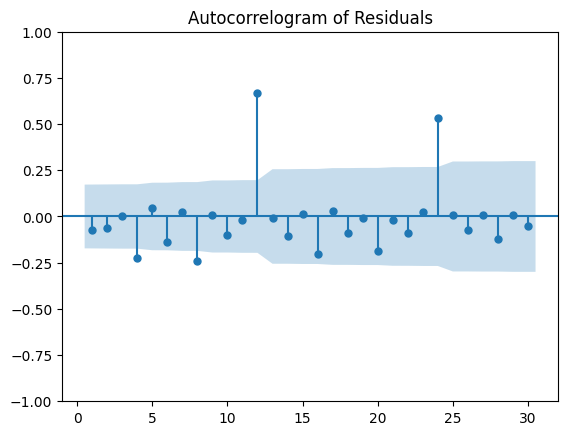

<Figure size 1000x500 with 0 Axes>

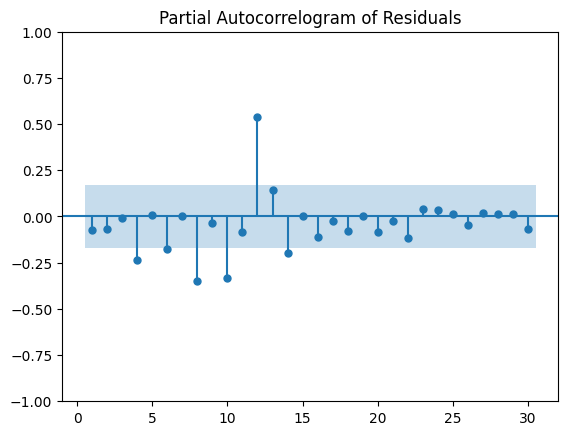

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30, zero=False)
plt.title("Autocorrelogram of Residuals")
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=30, zero=False)
plt.title("Partial Autocorrelogram of Residuals")
plt.show()

# Prédiction

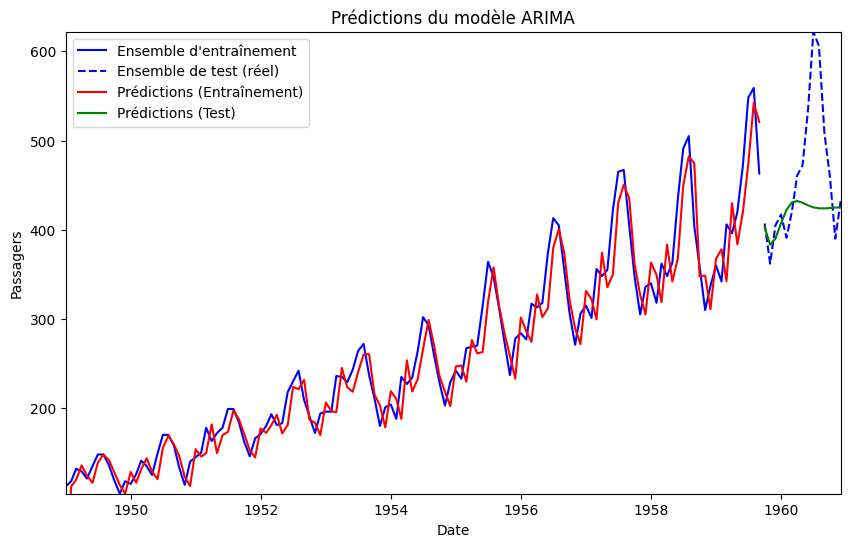

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Tracer les prédictions et les données réelles avec les courbes collées
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_predictions.index, test_predictions, label='Prédictions (Test)', color='green')

# Définir les limites des axes x et y pour une continuité visuelle
plt.xlim(train_data.index[0], test_data.index[-1])
plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))

plt.xlabel('Date')
plt.ylabel('Passagers')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_predictions)
train_mse = mean_squared_error(train_data, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(train_data, train_predictions)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, test_predictions)
test_mse = mean_squared_error(test_data, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_data, test_predictions)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                22.183944         54.144213
1      MSE               830.835014       6510.318943
2     RMSE                28.824209         80.686547
3       R²                 0.925421         -0.148361


In [22]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.8 MB/s eta 0:00:00


In [23]:
import pmdarima as pm

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df['Passengers'][:-15]
test_data = df['Passengers'][-15:]

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -589.217
Date:                Thu, 13 Nov 2025   AIC                           1190.435
Time:                        17:57:48   BIC                           1207.547
Sample:                    01-01-1949   HQIC                          1197.388
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6605      0.126      5.239      0.000       0.413       0.908
ar.L1          1.6235      0.041     39.770      0.000       1.543       1.703
ar.L2         -0.8951      0.041    -21.896      0.0

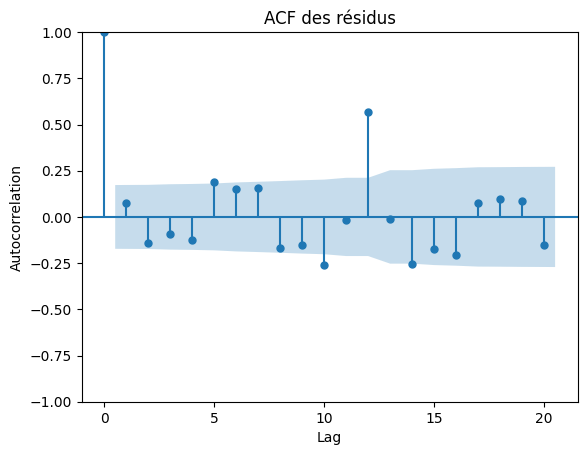

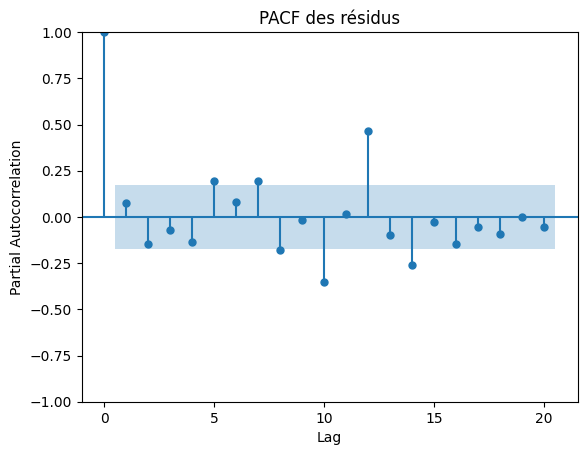

In [24]:
# Ajuster le modèle aux données
model.fit(train_data)
# Obtenir les résidus du modèle
residuals = model.resid()

# Tracer la fonction d'autocorrélation (ACF) des résidus
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF des résidus')
plt.show()

# Tracer la fonction d'autocorrélation partielle (PACF) des résidus
plot_pacf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF des résidus')
plt.show()

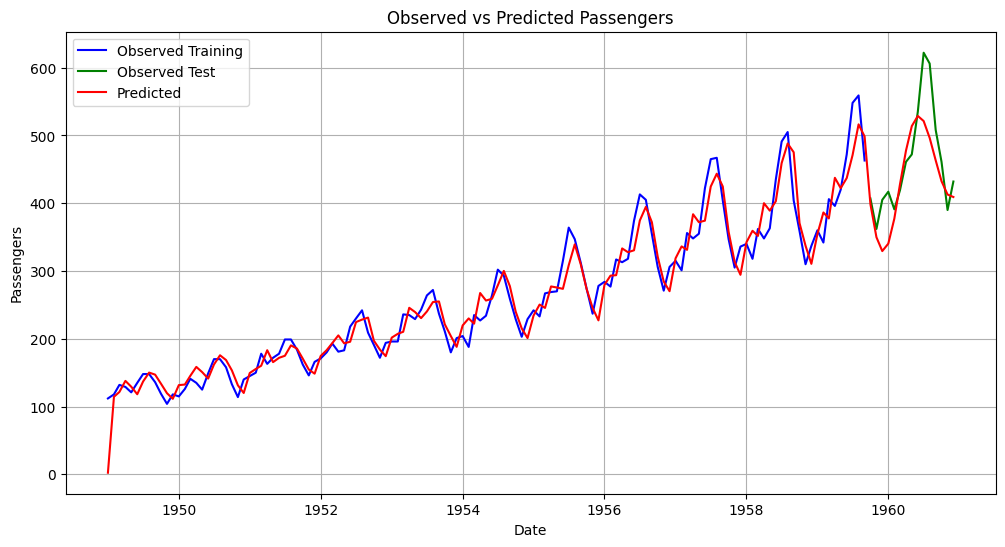

In [25]:
# Faire des prédictions sur l'ensemble d'entraînement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Faire des prédictions sur l'ensemble de test
n_periods = len(test_data)
predicted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concaténer les prédictions pour l'ensemble d'entraînement et de test
all_predictions = pd.concat([pd.Series(train_pred, index=train_data.index),
                             pd.Series(predicted, index=test_data.index)],
                            axis=0)

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed Training', color='blue')
plt.plot(test_data, label='Observed Test', color='green')
plt.plot(all_predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Calculer les mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_pred)
train_mse = mean_squared_error(train_data, train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(train_data, train_pred)

# Calculer les mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, predicted)
test_mse = mean_squared_error(test_data, predicted)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_data, predicted)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                19.581814         39.311057
1      MSE               656.693922       2679.987735
2     RMSE                25.626040         51.768598
3       R²                 0.941052          0.527275
